# Example end-to-end analysis
In this notebook, we will perform a simple end-to-end simulation, beginning by generating a log-normal field, transforming to redshift-space, adding foregrounds and noise, then removing the foregrounds, and estimating the power spectrum and correlation function.

In [1]:
import numpy as np
import numpy.fft as fft
import pylab as plt
import pyccl as ccl
plt.rcParams["figure.figsize"] = (14,7)

In [2]:
import fastbox
from fastbox.box import CosmoBox, default_cosmo
from fastbox.foregrounds import ForegroundModel
from nbodykit.lab import ArrayMesh
from nbodykit.algorithms.fftcorr import FFTCorr
from nbodykit.algorithms.fftpower import FFTPower
import time, sys

In [3]:
np.random.seed(41)

## Generate simulation box
Generate a Gaussian random realisation with a non-linear power spectrum on a (2 Gpc)^3 grid with 128^3 cells at redshift z=0.8. Then, paint biased HI onto the density field, apply a log-normal transformation, add linear and non-linear velocities to transform to redshift space, and finally rescale by the brightness temperature.

In [4]:
t0 = time.time()

# (1a) Generate Gaussian box (2 Gpc on each side, 128^3 grid, z=0.8)
box = CosmoBox(cosmo=default_cosmo, box_scale=(2e3,2e3,2e3), nsamp=128, 
               redshift=0.8, realise_now=False)
box.realise_density()

# (1b) Rescale tracer by bias [FIXME: Check this is being done in the right order]
tracer = fastbox.tracers.HITracer(box)
delta_hi = box.delta_x * tracer.bias_HI()

# (1c) Transform to a log-normal field
delta_ln = box.lognormal(delta_hi)

# (1d) Calculate radial velocity field (uses Gaussian density field; FIXME)
vel_k = box.realise_velocity(delta_x=box.delta_x, inplace=True)
vel_z = fft.ifftn(vel_k[2]).real # inverse FFT to get real-space radial velocity

# (1e) Transform to redshift space (also add non-linear velocity, sigma_nl=120 km/s)
delta_s = box.redshift_space_density(delta_x=delta_ln.real, velocity_z=vel_z, 
                                     sigma_nl=120., method='linear')

# (1f) Scale by mean brightness temperature (in mK), and include mean
signal_cube = tracer.signal_amplitude() * (1. + delta_s)

print("(1) Generating box complete (%3.3f sec)" % (time.time()-t0))

/home/phil/.local/lib/python3.7/site-packages/pyccl-2.2.1.dev3+g285066d5-py3.7.egg/pyccl/pk2d.py:198: RuntimeWarning: divide by zero encountered in log
  f, status = lib.pk2d_eval_multi(self.psp, np.log(k_use),
/home/phil/meerkat/fast21cmbox/fastbox/box.py:259: RuntimeWarning: invalid value encountered in true_divide
  Ax = 1.j * delta_k * self.Kx * (2.*np.pi/self.Lx) / k2
/home/phil/meerkat/fast21cmbox/fastbox/box.py:260: RuntimeWarning: invalid value encountered in true_divide
  Ay = 1.j * delta_k * self.Ky * (2.*np.pi/self.Ly) / k2
/home/phil/meerkat/fast21cmbox/fastbox/box.py:261: RuntimeWarning: invalid value encountered in true_divide
  Az = 1.j * delta_k * self.Kz * (2.*np.pi/self.Lz) / k2


(1) Generating box complete (3.462 sec)


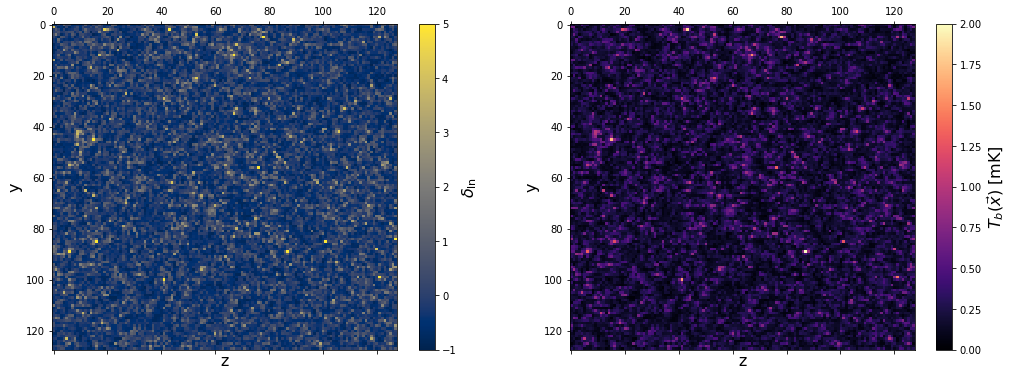

In [5]:
plt.subplot(121)
plt.matshow(delta_ln[10,:,:], vmin=-1., vmax=5., cmap='cividis', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$\delta_{\rm ln}$", fontsize=16)

plt.subplot(122)
plt.matshow(signal_cube[10,:,:], vmin=0., vmax=2., cmap='magma', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_b(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

## Add foregrounds
Generate Gaussian random realisations of Galactic synchrotron and extragalactic point sources using the parameters from Santos et al. (2005) Table 1, with foreground monopoles extrapolated from Planck down to 130 MHz.

In [6]:
t0 = time.time()

# Output frequency range
freqs = box.freq_array()
print("Frequency range: %3.1f -- %3.1f MHz\n" % (freqs[-1], freqs[0]))

# Angular pixels
ang_x, ang_y = box.pixel_array(redshift=box.redshift)


# FG model: Extragalactic point sources (~2.5K at 408 MHz = 26.7 K at 130 MHz, 
# see https://physics.richmond.edu/rsb-conference/presentation-pdfs/RSB%20-%20Kogut%20Introductory.pdf)
fg_extragal = ForegroundModel(box)
fg_extragal_map = fg_extragal.realise_foreground_amp(amp=57., beta=-1.1, monopole=26.7e3, 
                                                     smoothing_scale=0.1) # in mK
alpha_extragal = fg_extragal.realise_spectral_index(mean_spec_idx=-2.07, std_spec_idx=0.00002,
                                                    smoothing_scale=0.1)
fg_extragal_cube = fg_extragal.construct_cube(fg_extragal_map, alpha_extragal, freq_ref=130.)


# FG model: Galactic synchrotron (~133 K at 130 MHz, e.g. from Planck freq. plot)
fg_synch = ForegroundModel(box)
fg_synch_map = fg_synch.realise_foreground_amp(amp=700., beta=-2.4, monopole=133e3, 
                                               smoothing_scale=None) # in mK
alpha_synch = fg_synch.realise_spectral_index(mean_spec_idx=-2.8, std_spec_idx=0.00002,
                                              smoothing_scale=0.1)
fg_synch_cube = fg_synch.construct_cube(fg_synch_map, alpha_synch, freq_ref=130.)


# Add to data cube
fg_cube = fg_extragal_cube + fg_synch_cube

print("(2) Adding foregrounds complete (%3.3f sec)" % (time.time()-t0))

Frequency range: 630.1 -- 948.1 MHz

(2) Adding foregrounds complete (0.168 sec)


/home/phil/meerkat/fast21cmbox/fastbox/foregrounds.py:69: RuntimeWarning: divide by zero encountered in power
  C_ell = amp * (0.5*k_perp*r / 1000.)**(beta)


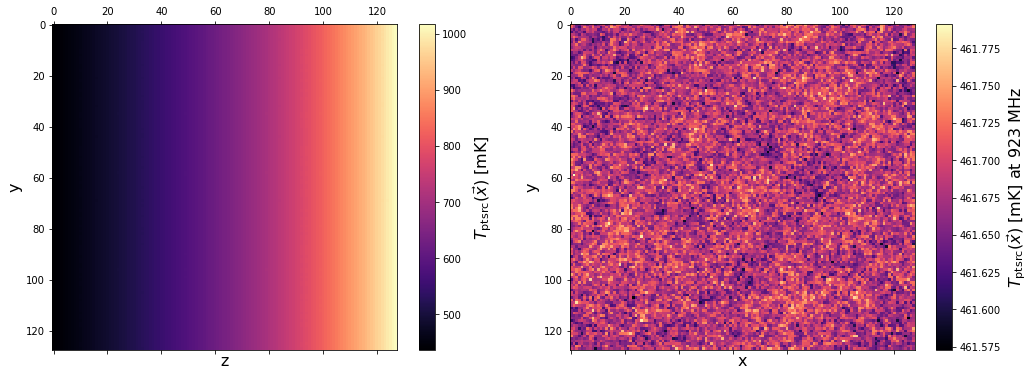

In [7]:
plt.subplot(121)
plt.matshow(fg_extragal_cube[10,:,:], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm ptsrc}(\vec{x})$ [mK]", fontsize=16.)
#plt.gcf().set_size_inches((8., 6.))

plt.subplot(122)
plt.matshow(fg_extragal_cube[:,:,10].T, cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm ptsrc}(\vec{x})$ [mK] at %d MHz" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

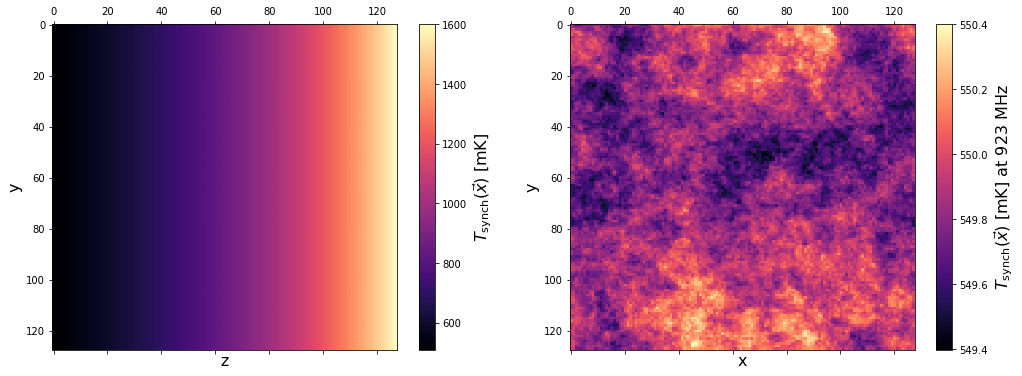

In [8]:
plt.subplot(121)
plt.matshow(fg_synch_cube[10,:,:], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm synch}(\vec{x})$ [mK]", fontsize=16.)

plt.subplot(122)
plt.matshow(fg_synch_cube[:,:,10].T, cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm synch}(\vec{x})$ [mK] at %d MHz" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

## Add radiometer noise
Adds a simple homogeneous white noise field for a MeerKAT-like multi-dish deep integration (64 dishes, 2 hours per pointing, assumed 1 degree FOV per pointing).

In [9]:
t0 = time.time()

# Generate homogeneous radiometer noise
noise_model = fastbox.noise.NoiseModel(box)
noise_cube = noise_model.realise_radiometer_noise(Tinst=18., tp=0.25, fov=1., Ndish=64)

print("(3) Adding noise complete (%3.3f sec)" % (time.time()-t0))

(3) Adding noise complete (0.099 sec)


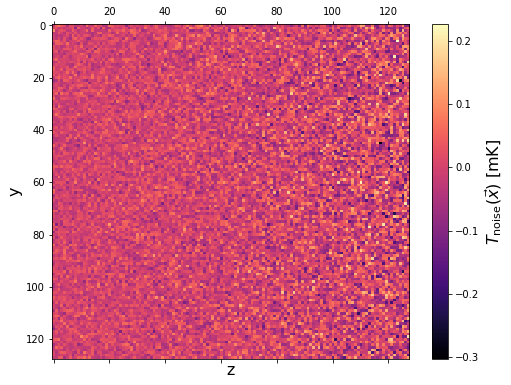

In [10]:
plt.matshow(noise_cube[10,:,:], cmap='magma', aspect='auto')
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm noise}(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((8., 6.))

## Construct final data cube

In [11]:
data_cube = signal_cube + fg_cube + noise_cube

## Apply foreground cleaning

In [12]:
t0 = time.time()

# Apply PCA cleaning
cleaned_cube, U_fg, amp_fg = fastbox.filters.pca_filter(data_cube, 
                                                         nmodes=3, 
                                                         return_filter=True)

print("(4a) Cleaning foregrounds complete (%3.3f sec)" % (time.time()-t0))

(4a) Cleaning foregrounds complete (0.286 sec)


In [13]:
t0 = time.time()

# Apply ICA cleaning
cleaned_cube_ica, ica_transform = fastbox.filters.ica_filter(data_cube, 
                                                             nmodes=3, 
                                                             return_filter=True)

print("(4b) Cleaning foregrounds complete (%3.3f sec)" % (time.time()-t0))

(4b) Cleaning foregrounds complete (0.438 sec)


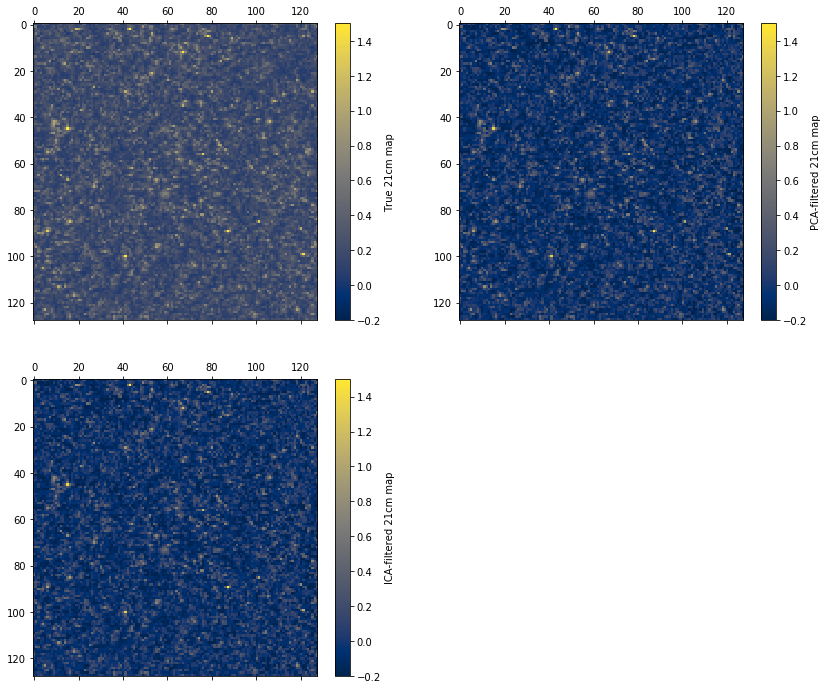

In [14]:
# Plot true and filtered fields
plt.subplot(221)
plt.matshow(signal_cube[10,:,:], cmap='cividis', vmin=-0.2, vmax=1.5, aspect='auto', fignum=False)
plt.colorbar(label="True 21cm map")

plt.subplot(222)
plt.matshow(cleaned_cube[10,:,:], cmap='cividis', vmin=-0.2, vmax=1.5, aspect='auto', fignum=False)
plt.colorbar(label="PCA-filtered 21cm map")

plt.subplot(223)
plt.matshow(cleaned_cube_ica[10,:,:], cmap='cividis', vmin=-0.2, vmax=1.5, aspect='auto', fignum=False)
plt.colorbar(label="ICA-filtered 21cm map")

plt.gcf().set_size_inches((14., 12.))

## Calculate power spectra

In [15]:
t0 = time.time()

# Subtract mean (as a function of frequency) from the data
mean_freq = np.mean(data_cube.reshape(-1, data_cube.shape[-1]), axis=0)
mean_sub_data = data_cube - mean_freq[np.newaxis,np.newaxis,:]

# Power spectra: input cosmo signal, data, FG-filtered data, theory
sig_k, sig_pk, sig_stddev = box.binned_power_spectrum(delta_x=signal_cube, nbins=50)
data_k, data_pk, data_stddev = box.binned_power_spectrum(delta_x=mean_sub_data, nbins=50)

proc_k, proc_pk, proc_stddev = box.binned_power_spectrum(delta_x=cleaned_cube, nbins=50)
ica_k, ica_pk, ica_stddev = box.binned_power_spectrum(delta_x=cleaned_cube_ica, nbins=50)

th_k, th_pk = box.theoretical_power_spectrum()

print("(5) Computing power spectra complete (%3.3f sec)" % (time.time()-t0))

/home/phil/.local/lib/python3.7/site-packages/numpy-1.19.2-py3.7-linux-x86_64.egg/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/phil/.local/lib/python3.7/site-packages/numpy-1.19.2-py3.7-linux-x86_64.egg/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/phil/.local/lib/python3.7/site-packages/numpy-1.19.2-py3.7-linux-x86_64.egg/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/phil/.local/lib/python3.7/site-packages/numpy-1.19.2-py3.7-linux-x86_64.egg/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/phil/.local/lib/python3.7/site-packages/numpy-1.19.2-py3.7-linux-x86_64.egg/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(5) Computing power spectra complete (22.404 sec)


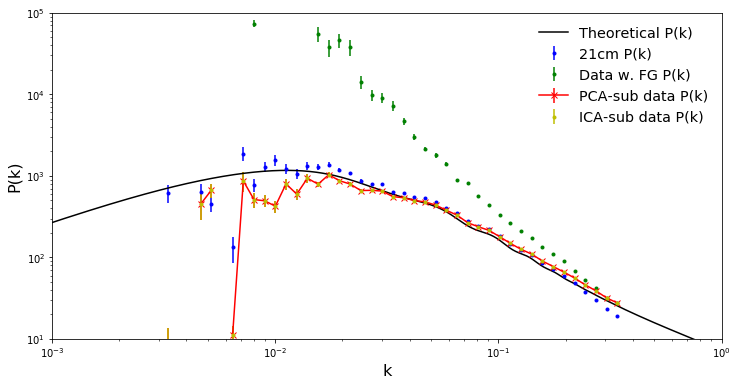

In [16]:
# Amplitude factor (for theoretical spectrum)
amp_fac = (tracer.signal_amplitude() * tracer.bias_HI())**2. # FIXME: No RSD contrib.

# Plot power spectra
plt.subplot(111)
plt.plot(th_k, th_pk * amp_fac, 'k-', label="Theoretical P(k)")
plt.errorbar(sig_k, sig_pk, yerr=sig_stddev, color='b', marker='.', ls='none', label="21cm P(k)")
plt.errorbar(data_k, data_pk, yerr=data_stddev, color='g', marker='.', ls='none', label="Data w. FG P(k)")
plt.errorbar(proc_k, proc_pk, yerr=proc_stddev, color='r', marker='x', label="PCA-sub data P(k)")
plt.errorbar(ica_k, ica_pk, yerr=ica_stddev, color='y', marker='.', ls='none', label="ICA-sub data P(k)")
plt.legend(loc='upper right', frameon=False, prop={'size':'x-large'})
plt.xlim((1e-3, 1e0))
plt.ylim((1e1, 1e5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("k", size=16)
plt.ylabel("P(k)", size=16)

plt.gcf().set_size_inches((12., 6.))

## Calculate correlation function

In [17]:
t0 = time.time()

# Convert fields to nbodykit meshes
boxsize = (box.Lx, box.Ly, box.Lz)
mesh_true = ArrayMesh(signal_cube, BoxSize=boxsize)
mesh_proc = ArrayMesh(cleaned_cube, BoxSize=boxsize)

# Correlation function of true signal
corrfn_true = FFTCorr(first=mesh_true, mode='1d', BoxSize=boxsize, 
                      los=[0, 0, 1], dr=2., rmin=20.0, rmax=200.)
corr_true, _ = corrfn_true.run()

# Perform high-pass filter on foreground-cleaned data
#highpass = lambda kperp, kpar: 1. - np.exp(-0.5 * (np.abs(kpar) / 0.009)**3.)
#cleaned_cube4_hp = box.apply_transfer_fn(fft.fftn(cleaned_cube4), transfer_fn=highpass)
#mesh_proc4_hp = ArrayMesh(cleaned_cube4_hp.real, BoxSize=boxsize)

# Correlation function of processed (FG-subtracted) signal
corrfn_proc = FFTCorr(first=mesh_proc, mode='1d', BoxSize=boxsize, 
                       los=[0, 0, 1], dr=2., rmin=20.0, rmax=200.)
corr_proc, _ = corrfn_proc.run()

print("(6) Calculating correlation function complete (%3.3f sec)" % (time.time()-t0))

(6) Calculating correlation function complete (0.944 sec)


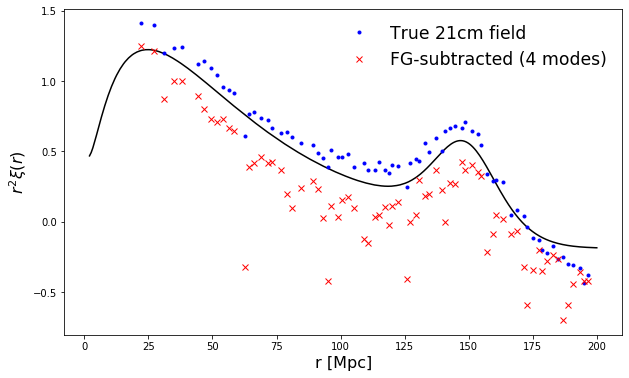

In [18]:
# Plot correlation functions and vanilla theoretical prediction
r = corr_true['r']
h = box.cosmo['h']

rr = np.linspace(2., 200., 300)
xi = ccl.correlation_multipole(box.cosmo, a=box.scale_factor, l=0, s=rr, beta=0.)
ampsq = (tracer.signal_amplitude() * tracer.bias_HI())**2.

plt.subplot(111)
plt.plot(rr, rr**2. * xi * ampsq, 'k-')
plt.plot(r, r**2. * corr_true['corr'], 'b.', label="True 21cm field")
plt.plot(r, r**2. * corr_proc['corr'], 'rx', label="FG-subtracted (4 modes)")

plt.legend(loc='upper right', frameon=False, prop={'size': 'xx-large'})
plt.xlabel("r [Mpc]", fontsize=16)
plt.ylabel(r"$r^2 \xi(r)$", fontsize=16)

plt.gcf().set_size_inches((10., 6.))

## Animated plot scanning through the data cube

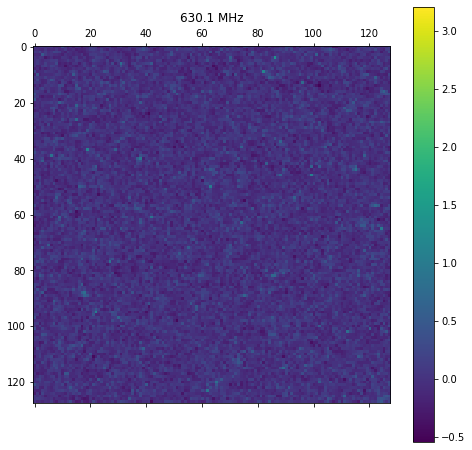

In [19]:
# Plot the cleaned data as a function of frequency
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
fastbox.plot.animate_field(cleaned_cube, box.freq_array(), coord_fmt="%3.1f MHz", interval=50, fig=fig)